In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
from time_series_preprocessing import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
AAPL = pd.read_csv("../../Stock-Price-Prediction/data/dataset/APPL.csv")
AAPL["Date"] = pd.to_datetime(AAPL["Date"])
AAPL.set_index("Date", inplace=True)

In [3]:
AAPL

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.845036,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.075386,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.530045,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.450966,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.126766,164101200
...,...,...,...,...,...,...
2024-04-08,169.029999,169.199997,168.240005,168.449997,168.449997,37425500
2024-04-09,168.699997,170.080002,168.350006,169.669998,169.669998,42451200
2024-04-10,168.800003,169.089996,167.110001,167.779999,167.779999,49709300


**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

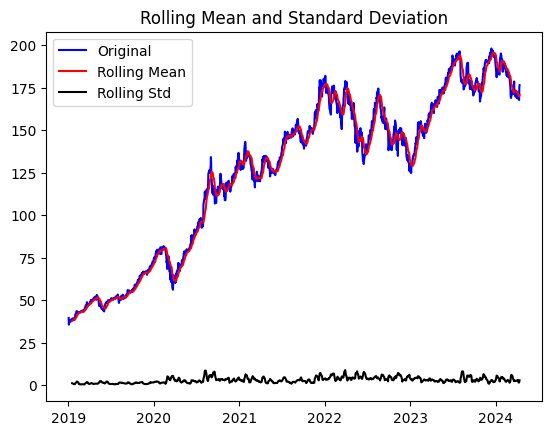

Results of Dickey-Fuller Test:
Test Statistics                  -1.530651
p-value                           0.518298
No. of Lags Used                  0.000000
Number of Observations Used    1328.000000
Critical Value (1%)              -3.435284
Critical Value (5%)              -2.863719
Critical Value (10%)             -2.567930
dtype: float64


In [4]:
df_close = AAPL['Close']    
test_stationarity(df_close)

p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

<Figure size 640x480 with 0 Axes>

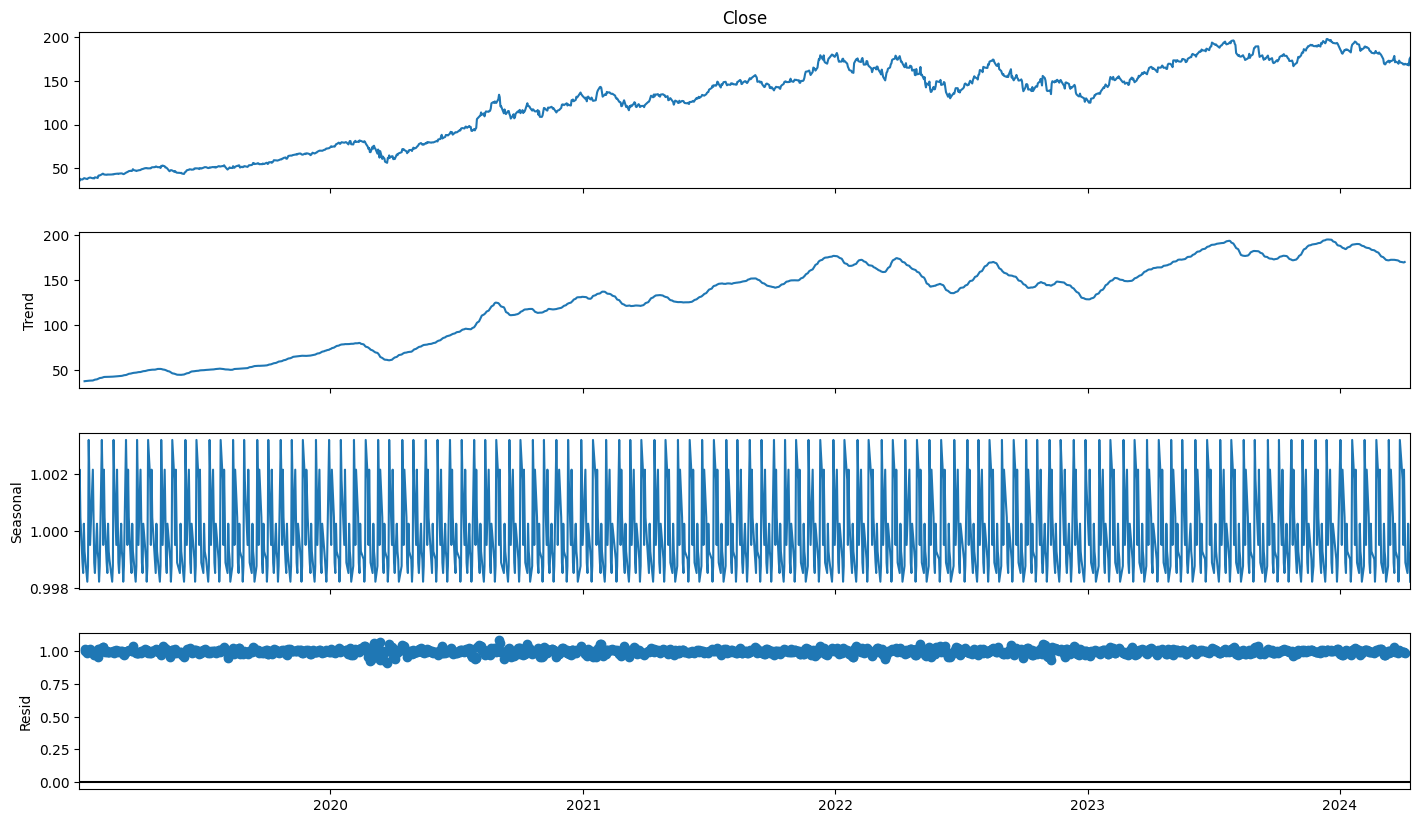

In [5]:
decompose_seasonality(df_close)

In [6]:
# Eliminate trend
df_log, detrended_series, moving_avg, std_dev = eliminate_trend(df_close)

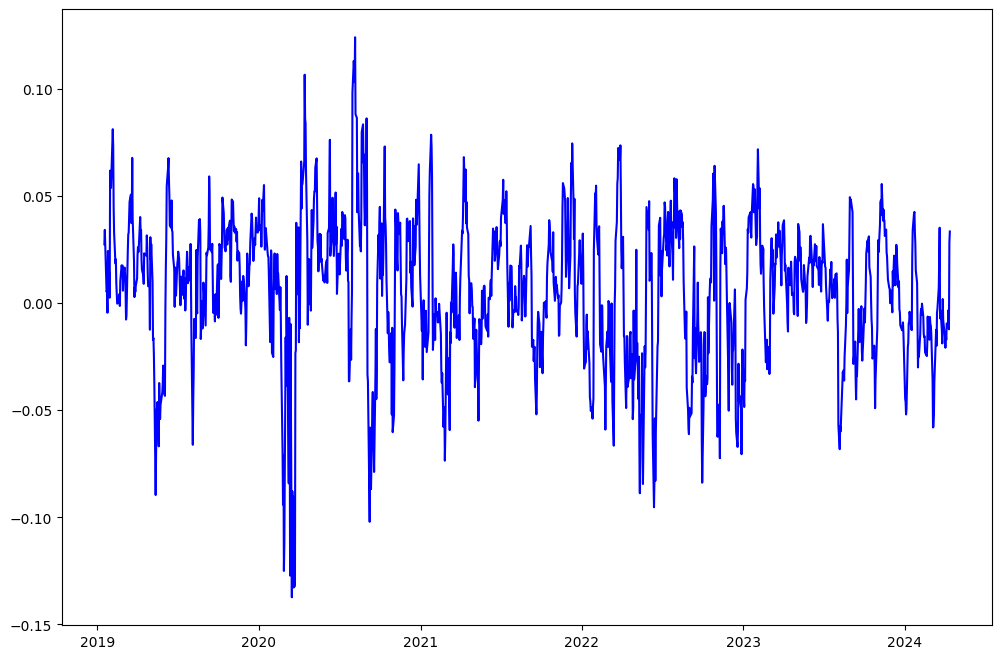

In [7]:
plt.figure(figsize=(12, 8))  
plt.plot(detrended_series, color="blue", label="Detrended Series")

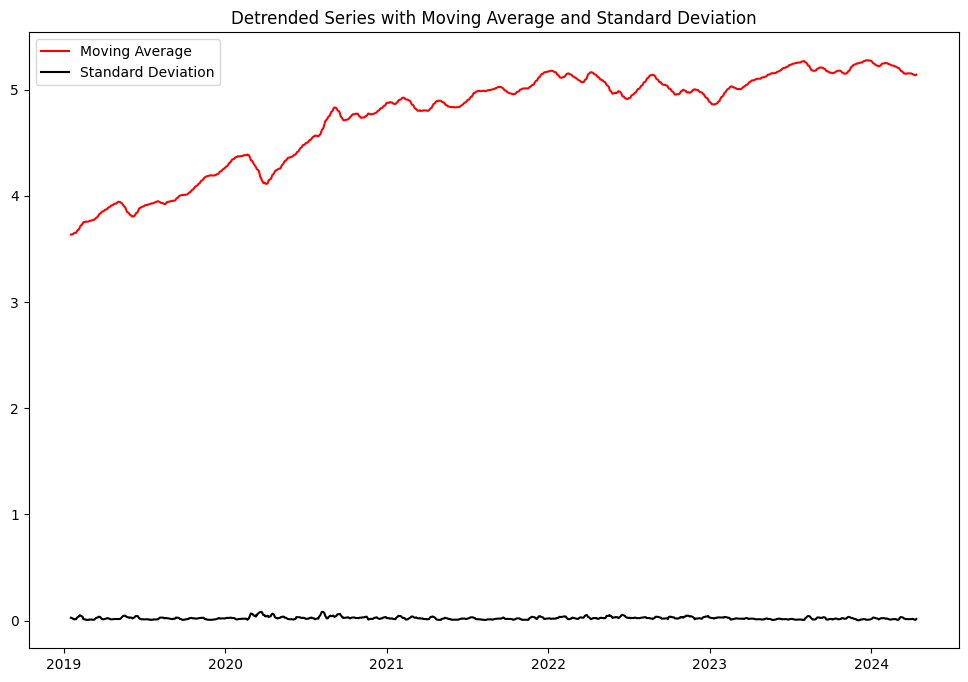

In [8]:
plt.figure(figsize=(12, 8))  
plt.plot(moving_avg, color="red", label="Moving Average")
plt.plot(std_dev, color="black", label="Standard Deviation")
plt.legend()
plt.title("Detrended Series with Moving Average and Standard Deviation")
plt.show()


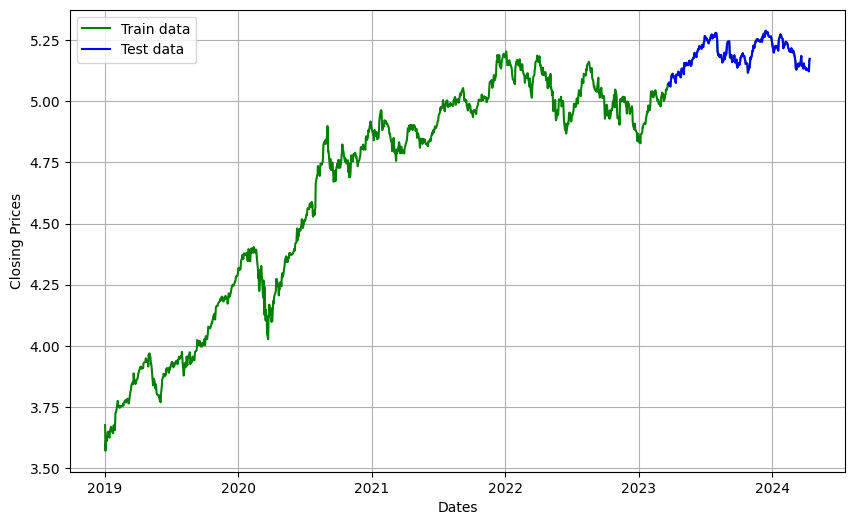

In [9]:
# Splitting the data into training and testing sets with 80-20 ratio
train_data, test_data = df_log[:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Grid Search ARIMA Model Hyperparameters

In [11]:
def tune_arima_parameters(data):
    p_values = [0, 1, 2, 4, 6, 8, 10]
    d_values = range(0, 3)
    q_values = range(0, 3)
    best_rmse = float('inf')
    best_params = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(data, order=(p, d, q))
                    results = model.fit()
                    predictions = results.predict(start=len(data), end=len(data) + 6, dynamic=False)  # Predict 7 days
                    rmse = math.sqrt(mean_squared_error(data[-7:], predictions))
                    print(f"Parameters: p={p}, d={d}, q={q}, RMSE={rmse}")
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = (p, d, q)
                except Exception as e:
                    print(f"Error occurred: {e}")
                    continue
    print("Best parameters:", best_params)
    return best_params

data = AAPL['Close']
best_params = tune_arima_parameters(data)
print("Best ARIMA parameters:", best_params)

Parameters: p=0, d=0, q=0, RMSE=44.87011046536362
Parameters: p=0, d=0, q=1, RMSE=42.59534594785747
Parameters: p=0, d=0, q=2, RMSE=41.28657481556109
Parameters: p=0, d=1, q=0, RMSE=6.551678317806988
Parameters: p=0, d=1, q=1, RMSE=6.5027410695802805
Parameters: p=0, d=1, q=2, RMSE=6.372516922603815
Parameters: p=0, d=2, q=0, RMSE=11.960771411887473
Parameters: p=0, d=2, q=1, RMSE=6.8446141960987275
Parameters: p=0, d=2, q=2, RMSE=6.7934591642225595
Parameters: p=1, d=0, q=0, RMSE=6.440612668411231
Parameters: p=1, d=0, q=1, RMSE=6.400728381689519
Parameters: p=1, d=0, q=2, RMSE=6.279352841201417
Parameters: p=1, d=1, q=0, RMSE=6.511741410364254
Parameters: p=1, d=1, q=1, RMSE=6.338915219560277
Parameters: p=1, d=1, q=2, RMSE=6.3984642888331695
Parameters: p=1, d=2, q=0, RMSE=20.784857444651603
Parameters: p=1, d=2, q=1, RMSE=6.804871441127691
Parameters: p=1, d=2, q=2, RMSE=6.759075555102948
Parameters: p=2, d=0, q=0, RMSE=6.409012044705962
Parameters: p=2, d=0, q=1, RMSE=6.3095140153

In [12]:
def ARIMA_ALGO(df):
    """
    Perform ARIMA modeling for stock prediction.

    Args:
    - df (pd.DataFrame): DataFrame containing stock data.

    Returns:
    - tuple: A tuple containing the ARIMA prediction, its corresponding RMSE, and the date of the prediction.
    """
    def arima_model(train, test):
        history = [x for x in train]
        predictions = list()
        for t in range(len(test)):
            model = ARIMA(history, order=(6, 0, 2))
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
        return predictions

    # Select 'Close' column for modeling
    quantity = df['Close'].values

    # Plot trend
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(df.index, df['Close'], 'green', label='Closing Prices')
    plt.legend()

    # Split data into train and test sets
    size = int(len(quantity) * 0.80)
    train, test = quantity[0:size], quantity[size:]

    # Fit ARIMA model
    predictions = arima_model(train, test)

    # Plot graph
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(df.index[size:], test, label='Actual Price')
    plt.plot(df.index[size:], predictions, label='Predicted Price')
    plt.legend()

    print()
    print("------")
    arima_pred = predictions[-1]
    last_date = df.index[size + len(predictions) - 1]  # Get the date of the last prediction
    print(f"Tomorrow's Closing Price Prediction by ARIMA ({last_date}):", arima_pred)

    # Calculate MSE
    error_mse = mean_squared_error(test, predictions)
    print("ARIMA MSE:", error_mse)

    # Calculate MAE
    error_mae = mean_absolute_error(test, predictions)
    print("ARIMA MAE:", error_mae)

    # Calculate RMSE
    error_rmse = math.sqrt(mean_squared_error(test, predictions))
    print("ARIMA RMSE:", error_rmse)
    
    # Calculate MAPE
    error_mape = np.mean(np.abs((test - predictions) / test)) * 100
    print("ARIMA MAPE:", error_mape)

    print("------")

    return arima_pred, error_mse, error_mae, error_rmse, error_mape, last_date


------
Tomorrow's Closing Price Prediction by ARIMA (2024-04-12 00:00:00): 175.2588155575628
ARIMA MSE: 4.952237481969725
ARIMA MAE: 1.6756527202368303
ARIMA RMSE: 2.2253623259976623
ARIMA MAPE: 0.9347718720743796
------


(175.2588155575628,
 4.952237481969725,
 1.6756527202368303,
 2.2253623259976623,
 0.9347718720743796,
 Timestamp('2024-04-12 00:00:00'))

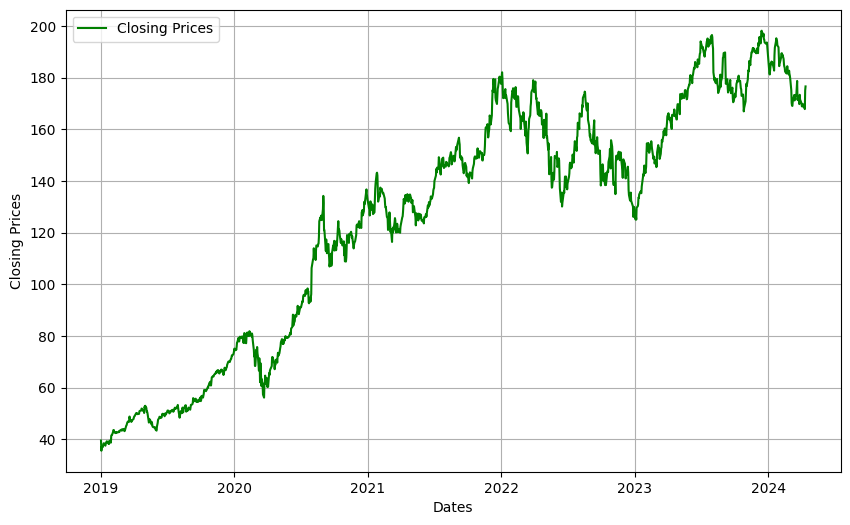

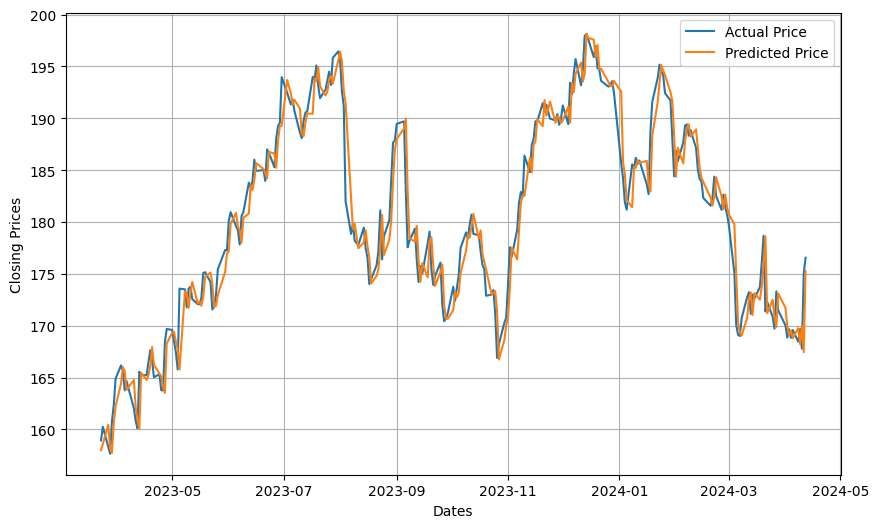

In [13]:
ARIMA_ALGO(AAPL)